# Toxic Spans Detection

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
from tqdm import trange

sns.set_style('darkgrid')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

![title](Images/pipeline.jpeg)

## Resumen

1. Quitando símbolos tóxicos (", espacios, !, etc) tenemos los siguientes resultados:
  - Hidden Markov Model: 0.321
  - Conditional Random Fields: 0.551
  - LSTM: 0.561 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
2. Quitando símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - Hidden Markov Model: 0.299
  - Conditional Random Fields: 0.546
  - LSTM: 0.556 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
3. Sin quitar símbolos tóxicos (", espacios, !, etc), es decir, dataset original:
  - Hidden Markov Model: 0.367
  - Conditional Random Fields: 0.501
  - LSTM: 0.535 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
4. Sin quitar símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - Hidden Markov Model: 0.367
  - Conditional Random Fields: 0.501
  - LSTM: 0.535 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
Para la LSTM lo mejor parece ser la opción 1. Lo mejor hasta ahora es con `(EMBEDDING_DIM = 20 HIDDEN_DIM = 20 EPOCHS = 25)` (0.581).

- [1. Exploración](#1)
  - [1.1 Mal etiquetados](#1.1)
- [2. Preprocesamiento](#2)
- [3. Modelos](#3)
  - [3.1 Hidden Markov Model](#3.1)
  - [3.2 Conditional Random Fields for Sequence Prediction](#3.2)
  - [3.3 LSTM](#3.3)
- [4. Evaluation](#4)

<a name = "1"></a>
# Exploración

In [2]:
from utils import color_toxic_words

In [3]:
train = pd.read_csv('Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})

In [4]:
train.head()

spans  \
0  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...   
1                       [33, 34, 35, 36, 37, 38, 39]   
2                                       [0, 1, 2, 3]   
3          [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]   
4                       [32, 33, 34, 35, 36, 37, 38]   

                                                text  
0  Another violent and aggressive immigrant killi...  
1  I am 56 years old, I am not your fucking junio...  
2                  Damn, a whole family. Sad indeed.  
3  What a knucklehead. How can anyone not know th...  
4  "who do you think should do the killing?"\n\nA...

Veamos las secciones tóxicas de algunas oraciones:

In [5]:
for i,(index,text) in enumerate(train.values[0:5]):
    print('{} - '.format(i) + color_toxic_words(index, text) + '\n'*2)

0 - Another violent and aggressive immigrant killing a innocent and intelligent US Citizen.... Sarcasm


1 - I am 56 years old, I am not your fucking junior pal. What you are saying makes no sense. I don't know what you are basing this on. The cheap black market crap is still coming up from Mexican nationals, and the good stuff from BC and Humbolt.  The I5 corridor is still just as busy, and they are still making a ton of money. Nothing has really changed except that the legal market has made it easy for anyone of legal age to buy it.  And the legal market is controlled by corporate growers with million dollar facilities, or a co-op of smaller growers. The Federal government "war on drugs" really has no impact on the legal market in Oregon. I don't see any glutton of weed, whatever that means.


2 - Damn, a whole family. Sad indeed.


3 - What a knucklehead. How can anyone not know this would be offensive??


4 - "who do you think should do the killing?"

Anyone and everyone. This is a

<a name = "1.1"></a>
### ¿Mal etiquetados?

En algunas oraciones pone los espacios, comas y otros signos como caracteres tóxicos, hay que tener cuidado y al final concatenarlos si es que hay dos o más palabras tóxicas juntas. En la competencia paracen concatenarlos, pero no son consistententes en otras partes.

In [6]:
very_toxic = [i for i,x in zip(train.index, train['spans']) if len(x)>100][0:5]

for i,(index,text) in zip(very_toxic, train.values[very_toxic]):
    print('{} - '.format(i) + color_toxic_words(index, text) + '\n'*2)

158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?


159 - [To say that juxtaposing and making the same a massacre and overtly implying that someone had something to do with that massacre is mere "negligence" is absolutely asinine]
You confer what is determined based upon the evidence is "extremely silly or stupid?"  Is that how you see federal courts and judges function?
[Those "journalists" knew one thing had nothing to do with the other]
What are you waiting for?  You better call Palin and tell her you have evidence that proves the "journalists" knew that the two were not connected because that'll prove there was actual malice.
Wait.  Why don't I hear you dialing?
[Your unrelated SCOTUS case is cute]
Let me get this straight.  The judge in this article used exactly the standard but you deem it as "unrelated?"
You sir, are in complete and completely irrational denial.  It 

Y hay otros que definitivamente están mal etiquetados, donde no ponen lenguaje tóxico donde realmente sí lo hay.

In [7]:
actually_toxic = [27, 60, 82, 134, 382]

for index,text in train.values[actually_toxic]:
    print(color_toxic_words(index, text) + '\n'*2)

The malignant narcissist, mentally deranged sociopath, bigot, rascist, disingenuous blowhard and pathological liar, has now certified himself as a fascist. How much longer before his GOP sycophants and suckees say, "Enough!", and demand this repugnant, excrement-spewing fool's ouster?


the is NO CONSENSUS you ignorant loser, NONE, nothing but debate, thousands of scientist do not agree period, we dont need to move from anything other than left wing stupidity like yours.


aa nadda showing the usual stupidity, its clowns like you that live outside reality, see pal canada needs the usa, the usa does not need us. , dont get me wrong, trudeau an ignorant child with no leadership skills doing real damage to canada with bs like carbon taxes...


Try reading my entire comment again, except slower, and then take a few moments for reflection, days if need be. If by then you still don't understand that the Trumpster is Putins bitch, you'll never get it.


You are just a stick buthole!




<a name = "2"></a>
## Preprocesamiento
Primero sería mejor tener las palabras tóxicas que los caracteres, también hay que tener cuidado cuando marcan un espacio o algún signo de puntuación como tóxico, al final sólo hay que concatenar si hay dos palabras tóxicas juntas (por hacer). También hay que pasar todo a minúscula y hacer el análisis en minúscula.

In [8]:
import string
from utils import remove_symbols, completely_toxic

In [9]:
text = 'fuck you idiot!!!'
index = np.arange(len(text)).tolist()

print(color_toxic_words(index, text))
print(color_toxic_words(remove_symbols(index, text), text))

fuck you idiot!!!
fuck you idiot!!!


Pondremos los que tienen [ ] como completamente tóxicos para ver qué sale.

In [10]:
# clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]

# train['spans_clean'] = clean_spans

Ahora los que estaban como [ ] son completamente tóxicos.

In [11]:
# length_zero = [i for i,x in zip(train.index, train['spans']) if x == []][0:3]

# for i, (index,text,index_clean) in zip(length_zero, train.values[length_zero]):
#     print('{} - '.format(i) + color_toxic_words(index_clean, text) + '\n'*2)

Quitamos símbolos.

In [12]:
indices_clean = [remove_symbols(index, text) for index,text in 
                 zip(train['spans'], train['text'])]

train['spans_clean'] = indices_clean

Veamos como se ven si lo hacemos así:

In [13]:
very_toxic = [i for i,x in zip(train.index, train['spans']) if len(x)>100][0:3]

for i, (index,text,index_clean) in zip(very_toxic, train.values[very_toxic]):
    print('{} - '.format(i) + color_toxic_words(index, text))
    print('{} - '.format(i) + color_toxic_words(index_clean, text) + '\n'*2)

158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?
158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?


159 - [To say that juxtaposing and making the same a massacre and overtly implying that someone had something to do with that massacre is mere "negligence" is absolutely asinine]
You confer what is determined based upon the evidence is "extremely silly or stupid?"  Is that how you see federal courts and judges function?
[Those "journalists" knew one thing had nothing to do with the other]
What are you waiting for?  You better call Palin and tell her you have evidence that proves the "journalists" knew that the two were not connected because that'll prove there was actual malice.
Wait.  Why don't I hear you dialing?
[Your unrelated SCOTUS case is cute]
Let me get

También pasemos a minúscula el texto para el entrenamiento:

In [14]:
train['text'] = train['text'].apply(lambda x:x.lower())

<a name = "3"></a>
## Modelos

En la competencia usarán el F1 score para evaluar como sigue:

<blockquote cite="http://www.worldwildlife.org/who/index.html">
To evaluate the responses of a system participating in the challenge, we employ the $F_{1}$ score, as in [1]. Let system $A_i$ return a set $S^{t}_{A_{i}}$ of character offsets, for parts of the post found to be toxic. Let $G^{t}$ be the character offsets of the ground truth annotations of $t$. We compute the $F_{1}$ score of system $A_i$ with respect to the ground truth $G$ for post $t$ as follows, where $|·|$ denotes set cardinality.
    
$$ F_{1}^{t}(A_{i}, G) = \dfrac{2 \cdot P^{t}(A_{i}, G) \cdot R^{t}(A_{i}, G)}{P^{t}(A_{i}, G) + R^{t}(A_{i}, G)}$$
    
$$ P^{t}(A_{i}, G) = \dfrac{|S^{t}_{A_{i}} \cap S^{t}_{A_{i}}|}{|S^{t}_{A_{i}}|} $$
    
$$ R^{t}(A_{i}, G) = \dfrac{|S^{t}_{A_{i}} \cap S^{t}_{A_{i}}|}{|S^{t}_{G}|} $$    
    
If $S^{t}_{G}$ is empty for some post $t$ (no gold spans are given for $t$), we set $F_{1}^{t}(A_{i}, G)$ if $S^{t}_{A_{i}}$ is also empty, and $F_{1}^{t}(A_{i}, G) = 0$ otherwise. We finally average $F_{1}^{t}(A_{i}, G)$ over all the posts $t$ of an evaluation dataset $T$ to obtain a single score for system $A_{i}$.

</blockquote>

In [15]:
from utils import separate_words, get_index_toxic_words

In [16]:
# La siguiente función viene en el GitHub de la competencia.
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)

<a name = "3.1"></a>
### Hidden Markov Model

In [17]:
import nltk
from nltk.corpus import treebank
from nltk.tag import HiddenMarkovModelTrainer
from nltk.tokenize import word_tokenize

En nuestro caso debemos etiquetar en `toxic` y `non_toxic`.

In [18]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append((token, 'toxic'))
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append((token, 'non_toxic'))
            
    train_data.append(tagged_tokens)

Entrenamos:

In [19]:
trainer = HiddenMarkovModelTrainer()
tagger_HMM = trainer.train_supervised(train_data)

Ahora hagamos algunos experimentos:

In [20]:
text = 'fucking piece of shit, suck my dick'
tagged_sentence = tagger_HMM.tag(word_tokenize(text))
toxic_index = get_index_toxic_words(text, tagged_sentence)

print(tagged_sentence)
print(color_toxic_words(toxic_index, text))

[('fucking', 'toxic'), ('piece', 'toxic'), ('of', 'toxic'), ('shit', 'toxic'), (',', 'non_toxic'), ('suck', 'toxic'), ('my', 'toxic'), ('dick', 'toxic')]
fucking piece of shit, suck my dick


In [21]:
text = 'have a nice day, my dear nigger'
tagged_sentence = tagger_HMM.tag(word_tokenize(text))
toxic_index = get_index_toxic_words(text, tagged_sentence)

print(tagged_sentence)
print(color_toxic_words(toxic_index, text))

[('have', 'non_toxic'), ('a', 'non_toxic'), ('nice', 'non_toxic'), ('day', 'non_toxic'), (',', 'non_toxic'), ('my', 'non_toxic'), ('dear', 'non_toxic'), ('nigger', 'toxic')]
have a nice day, my dear nigger


Veamos que score tenemos en el dataset de `test` y comparemos nuestras predicciones:

In [22]:
scores_HMM = []

for gold_index, text in test.values:
    tagged_sentence = tagger_HMM.tag(word_tokenize(text.lower()))   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text))   
    print(colored('Gold: ', color='yellow', attrs=['bold']) + 
          color_toxic_words(gold_index, text) + '\n'*2)
    
    scores_HMM.append(f1(prediction_index, gold_index))

Pred: Because he's a moron and a bigot. It's not any more complicated than that.
Gold: Because he's a moron and a bigot. It's not any more complicated than that.


Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
Gold: Trump Claimed that Russia w

Pred: This new has made the A/P, CNBC, Bloomberg,  etc.

The PM is an international embarrassment, and looks ridiculous..

Harper has to GO! NOW!
.
.
.
.




oh, wait...
Gold: This new has made the A/P, CNBC, Bloomberg,  etc.

The PM is an international embarrassment, and looks ridiculous..

Harper has to GO! NOW!
.
.
.
.




oh, wait...


Pred: Ride those trailer brakes, you morons!
Gold: Ride those trailer brakes, you morons!


Pred: Of course you cannot defend your own hypocrisy...I see you are starting of 2017 on the same losing track as always...oh, well, no cure for stupidity.
Gold: Of course you cannot defend your own hypocrisy...I see you are starting of 2017 on the same losing track as always...oh, well, no cure for stupidity.


Pred: another comment proving yet again how completely brain washed stupid the likes of you have become
Gold: another comment proving yet again how completely brain washed stupid the likes of you have become


Pred: It didn't take much rope for the vil

Pred: Trump and right wing nuts are is such huge hypocrites. They're really pathetic. 

Trump Was Fine With Ted Nugent Joking About Killing The President http://www.huffingtonpost.com/entry/trump-ted-nugent-donald-trump_us_592f1ec9e4b09ec37c31577e?k8l
Gold: Trump and right wing nuts are is such huge hypocrites. They're really pathetic. 

Trump Was Fine With Ted Nugent Joking About Killing The President http://www.huffingtonpost.com/entry/trump-ted-nugent-donald-trump_us_592f1ec9e4b09ec37c31577e?k8l


Pred: "Santa Barbara feel." You mean walkable, well kept sidewalks. Livable, nice even. Not the dumping ground for homeless drug addicts and prostitutes that it looks like now. The Ammo Can has enough parking. I never see that lot full. I do see all the snow from that lot pushed in the way of any one on a bike or walking.

People in Anchorage need to get off their butts and walk to a business. Their doctors will be happier, and they will be healthier.
Gold: "Santa Barbara feel." You mean w

Pred: Oh my here we go again.....Another day in the lives of hysterical hypocrite liberals and their Russian Boogey Man conspiracies. Democrats obvisiously  so butthurt over Trumps win that all they have left is impeachment nonsense and verbal attacks to distract the public from their own gross ignorance and anti America, un American direction of their political party.
Gold: Oh my here we go again.....Another day in the lives of hysterical hypocrite liberals and their Russian Boogey Man conspiracies. Democrats obvisiously  so butthurt over Trumps win that all they have left is impeachment nonsense and verbal attacks to distract the public from their own gross ignorance and anti America, un American direction of their political party.


Pred: If you're dumb enough to believe him on this, then I've got a bridge in Brooklyn I will sell you...
.
The guy is a pathological liar.  Don't believe anything he says.  It's all lies.
Gold: If you're dumb enough to believe him on this, then I've got

Pred: You must not have read the part where I said "on a lighter note " .To a person who just turned on a TV it would look like something out of a crazy comedy movie .  No real hockey fan would want to attend a UAA hockey game and watch that goofball stuff.   You don't see Aces crowds , NHL crowds , or even other college hockey teams fans acting like they all just escaped a trailer park. There's a reason so few attend UAA hockey games----and showing those fans acting loonie tunes is one of the reasons. I was offering advice to help with UAA's pathetic attendance problems---saying don't show stuff like that on TV if you want real hockey fans to attend. I couldn't care in the least if you consider my comments credible or not. The bottom line is :  if UAA wants to draw more fans to games---they'll stop showing crowd shots of craziness .  Fans want to watch the game----not see tons of kids bouncing off the walls .
Gold: You must not have read the part where I said "on a lighter note " .To 

Pred: Apparently this nation isn't ready for a woman as president yet, even a highly qualified and intelligent woman with a lot of international diplomatic experience; but it's equally apparent this nation will accept an ignorant man with no governing, diplomatic or military experience, who fobs his business debts of on banks, partners and contractors, lies nonstop, tweets inanely at the wee hours, and has less attention span than a fruit fly.

A college education, as you know, doesn't even guarantee literacy. Most of those voters probably had business degrees, which means, social and economic conservative mixed with social pretenses, bigotry toward working people, and a distrust or disrespect toward women. This election was an eye-opener for me.
Gold: Apparently this nation isn't ready for a woman as president yet, even a highly qualified and intelligent woman with a lot of international diplomatic experience; but it's equally apparent this nation will accept an ignorant man with no g

Another liar just like Trump. I think only idiots..............
Gold: http://www.politicususa.com/2016/09/02/trump-craven-maniacal-david-bossie-clinton-character-assassin.html

New Trump Hire Proves Hillary Clinton’s Vast Right Wing Conspiracy is Real
Trump's new Deputy Campaign Manager, Citizens United President David Bossie, "has devoted his career ever since to trying to tear down Hillary Clinton"

There is no disguising the truth: Bossie will be assisting Kellyanne Conway as an anti-Clinton character assassin, and Hillary for America Chair John Podesta released the following statement:

“David Bossie is so craven and maniacal that in the heyday of the overreaching, Gingrich-era Congress, the top Whitewater conspiracy theorist in the House had to fire him for doctoring evidence. He has devoted his career ever since to trying to tear down Hillary Clinton

Another liar just like Trump. I think only idiots..............


Pred: why would citizens who demand the truth go on trial? utter

Pred: He actually makes morons look great.  How much longer before he's impeached?
Gold: He actually makes morons look great.  How much longer before he's impeached?


Pred: He's a useful idiot - a counterweight to similar out of touch characters such as Maddow and Matthews, who have done their fair share of conspiracy theorizing and conjecture over the last 6 months (most of which have fallen flat - like Maddow's cringe worthy tax return coverage). Difference is, a fringe group within the right follow Jones. Maddow and Matthews on the other hand, are "journalists" on major networks.
Gold: He's a useful idiot - a counterweight to similar out of touch characters such as Maddow and Matthews, who have done their fair share of conspiracy theorizing and conjecture over the last 6 months (most of which have fallen flat - like Maddow's cringe worthy tax return coverage). Difference is, a fringe group within the right follow Jones. Maddow and Matthews on the other hand, are "journalists" on ma

Pred: Let us know when you actually have any evidence.

We've been waiting for over a year now.

Put up or shut up.
Gold: Let us know when you actually have any evidence.

We've been waiting for over a year now.

Put up or shut up.


Pred: You are so correct SKL - the left makes such a big deal about so called "bullying" yet it's perfectly fine if they do it.  They're such disgraceful hypocrites.
Gold: You are so correct SKL - the left makes such a big deal about so called "bullying" yet it's perfectly fine if they do it.  They're such disgraceful hypocrites.


Pred: I am a firm believer that stupid individuals cause much more harm than malicious individuals.

This has very strong support in academic research. See the following paper:

_The Basic Laws of Human Stupidity_ at

https://trusttheneighbors.files.wordpress.com/2016/05/blhs.pdf

-- Paul
Gold: I am a firm believer that stupid individuals cause much more harm than malicious individuals.

This has very strong support in academic 

Pred: SAYS THE OLD WHITE LADY HER SELF outsider77 have to make it about so called oppressed niggers. and old people waiting to die? come the fuck on your're a moron
Gold: SAYS THE OLD WHITE LADY HER SELF outsider77 have to make it about so called oppressed niggers. and old people waiting to die? come the fuck on your're a moron


Pred: One idiot so far and it happens to be you.
Gold: One idiot so far and it happens to be you.


Pred: They have the White House, the House, and the Senate and they can't govern themselves out of a paper bag.  But hey, keep ginning up the race baiting cause that'll get the twice removed judge into office.  Maybe that idiot will help you.
Gold: They have the White House, the House, and the Senate and they can't govern themselves out of a paper bag.  But hey, keep ginning up the race baiting cause that'll get the twice removed judge into office.  Maybe that idiot will help you.


Pred: Anti-vaccine fools reap what you sow.
Gold: Anti-vaccine fools reap what y

Pred: But did he have any attack chickens?
Saw a pop up selling full auto assault chickens 
And there is no background check to own and can be easily concealed and are even allowed in schools.
Meanwhile yesterday cell phones accounted for 63 deaths by distracted drivers.
It's not the weapon stupid it's the person using it.
Gold: But did he have any attack chickens?
Saw a pop up selling full auto assault chickens 
And there is no background check to own and can be easily concealed and are even allowed in schools.
Meanwhile yesterday cell phones accounted for 63 deaths by distracted drivers.
It's not the weapon stupid it's the person using it.


Pred: Jenkins wishes he could be as big a buffoon as Trump.
His best efforts were 30 years ago.
He only achieved small mindedness, speciousness and sanctimony.
Sad. Weak.
Gold: Jenkins wishes he could be as big a buffoon as Trump.
His best efforts were 30 years ago.
He only achieved small mindedness, speciousness and sanctimony.
Sad. Weak.


Pred

Pred: there it is in a 'nutshell'.  
fear, loathing, and hatred of  'liberals' is what drives these people.  
they would vote for a slate of kangaroos provided that the kangaroos were portrayed as the opposition to the 'liberal agenda'.

pathetic and mindless.
Gold: there it is in a 'nutshell'.  
fear, loathing, and hatred of  'liberals' is what drives these people.  
they would vote for a slate of kangaroos provided that the kangaroos were portrayed as the opposition to the 'liberal agenda'.

pathetic and mindless.


Pred: If you're stupid enough to have a back yard in bear territory, yes.
Gold: If you're stupid enough to have a back yard in bear territory, yes.


Pred: Oh trust me, the first pockets he will be picking are yours lol! Your a fool if you don't get that. I'm pro not letting any of those bastards in this country but your barking up the wrong tree. Vote libertarian
Gold: Oh trust me, the first pockets he will be picking are yours lol! Your a fool if you don't get that. I'm

Pred: Lol they all steal. We supported eu too. You think democrats don't enjoy it. Now explain why both sides disliked trump? Probably because he heartened to bring down there game. Thanks for pointing out that trump wasn't a thing during brexit. Once again couldn't figure out the point. People dislike the guise of refugees/ immigrants and the lovey dovey BS that goes along with it. I don't need a lesson on that and it was not even my point. Once again trump and farage and the next eu leaders are very relative to the point of immigration. My second point was the fact that all countries steal from there citizens and launder. We citizens get screwed from every country. You can say the we launder to the USA but it's politicians, republican and democrat. The USA launders to ME, Canada etc and the liberals and conservatives here are happy. They all seem to dislike trump which should be a big clue to his relativity in not only immigration but all policies. Once again I can clearly see the id

Pred: I remember when lying in politics was much more imaginative.
Now they just say anything stupid.
Gold: I remember when lying in politics was much more imaginative.
Now they just say anything stupid.


Pred: Stupid argument, although I hesitate to even call it an argument.  Try addressing the issue, instead of making idiotic remarks.
Gold: Stupid argument, although I hesitate to even call it an argument.  Try addressing the issue, instead of making idiotic remarks.


Pred: Hopefully no Habs d-man is silly enough to trip a guy going in full speed ;-)
Gold: Hopefully no Habs d-man is silly enough to trip a guy going in full speed ;-)


Pred: Lets just coddle these idiotic standoff perps and let them have their way. Next thing you know bank robbers will be given getaway cars for their timely escape. We dont want these criminals to be late to the next hillary rally.
Gold: Lets just coddle these idiotic standoff perps and let them have their way. Next thing you know bank robbers will be

Pred: So, we create a crap shoot lottery to fund education? Along with closing 1-2 Pioneer Homes (to save money) and throwing seniors out on the street, if I as I suspect many have no place else to go? All to protect the wealthy from paying into a balanced an progressive tax plan?  Is this truly the kind of state we as a collective wish to create? How much lower can our Republican lead Senate drop to? 

I have no kids to educate nor do I have any family or anyone I know living in a Pioneer Home (so I have no stake in this), but I do know that I am willing to pay into a progressive income and/or sales tax within a balanced plan to insure that seniors are housed and that your kids are educated. 

This is about creating a common sense, responsible, balanced, and compassionate Alaskan society for all, not an everyone for themselves, statewide dystopia. 

This is not fiscal responsibility; this is fiscal idiocy.
Gold: So, we create a crap shoot lottery to fund education? Along with closing 

Pred: Who is this clown? A lazy bum who sits allday writing jiberish - he's doing americans a favour -you can tell he is a half wit - all half wits bring up racism because they can;t think for themselves....
Gold: Who is this clown? A lazy bum who sits allday writing jiberish - he's doing americans a favour -you can tell he is a half wit - all half wits bring up racism because they can;t think for themselves....


Pred: Is there anyone who CARES what Schatz thinks ???  He needs to return to being the non-entity that he always has been. BACK to your hole, little worm, and PLEASE....be quiet.
Gold: Is there anyone who CARES what Schatz thinks ???  He needs to return to being the non-entity that he always has been. BACK to your hole, little worm, and PLEASE....be quiet.


Pred: You mean the 15 million worthless, lazy, entitled, idiot scumbags who will drop their insurance and force hospitals and other caregivers stick their bill to the rest of us?
Gold: You mean the 15 million worthless, 

My kid was just told to choose a university in another part of the country
Gold: Attention all refugees!!
Montreal wants you.
Those idiots just killed tourism
My kid was just told to choose a university in another part of the country


Pred: The result of people who believe the government ( The United States of America ) owes them a better life. When In actuality it is the essence of stupidity. If you want to be a part of,America, Life, Liberty and Pursuit of Happiness. you have to work at it. If this was the result of students from any school in America that school should be ashamed of itself.
Gold: The result of people who believe the government ( The United States of America ) owes them a better life. When In actuality it is the essence of stupidity. If you want to be a part of,America, Life, Liberty and Pursuit of Happiness. you have to work at it. If this was the result of students from any school in America that school should be ashamed of itself.


Pred: Trump is a buffoon.
And 

Pred: It will be interesting to see how the right deals with (or doesn't) with O'Lielly. We've already seen that the LEFT is consistent in their values when it comes to Weinstein - they've condemned and cut ties to him, etc.


How much time do you think the right will spend on O'Lielly's predation? Even 1/10th the time they spent on Weinstein? Or will they, once again, be flaming hypocrites on this?
Gold: It will be interesting to see how the right deals with (or doesn't) with O'Lielly. We've already seen that the LEFT is consistent in their values when it comes to Weinstein - they've condemned and cut ties to him, etc.


How much time do you think the right will spend on O'Lielly's predation? Even 1/10th the time they spent on Weinstein? Or will they, once again, be flaming hypocrites on this?


Pred: Dion one of the four idiots overseeing the destruction of Canada
Gold: Dion one of the four idiots overseeing the destruction of Canada


Pred: Lame and stupid attempt at humor.
Gold: La

Pred: Bunch of entitled whiners and beggars...but once again, our inherent politeness makes us doormats and chumps.
Gold: Bunch of entitled whiners and beggars...but once again, our inherent politeness makes us doormats and chumps.


Pred: Pence managed the transition.
There is no way that he could have avoided knowing everything about Flynn's activities.
He plays a good 'dumb' with those droopy, puppy-dog, poor-me eyebrows.
Gold: Pence managed the transition.
There is no way that he could have avoided knowing everything about Flynn's activities.
He plays a good 'dumb' with those droopy, puppy-dog, poor-me eyebrows.


Pred: Good: perhaps Dunleavy should be expelled from the Senate for religious intolerance and stupidity in general: the little man is dangerous to himself and others!
Gold: Good: perhaps Dunleavy should be expelled from the Senate for religious intolerance and stupidity in general: the little man is dangerous to himself and others!


Pred: I am glad this low life will rot

Pred: I thought that Austen Ivereigh's analysis was quite good and it was telling that Burke's fingers were all over this and that he was the one who was urging Festing to overreact.  I am glad that Pope Francis has been blessed with such a bumbling fool as his main opponent.
Gold: I thought that Austen Ivereigh's analysis was quite good and it was telling that Burke's fingers were all over this and that he was the one who was urging Festing to overreact.  I am glad that Pope Francis has been blessed with such a bumbling fool as his main opponent.


Pred: Close the MSM down, get rid of the jews that run them..they are the problem
Gold: Close the MSM down, get rid of the jews that run them..they are the problem


Pred: That's stupid.
Gold: That's stupid.


Pred: you mean NOT Russia?

you know since Trump was elected  and even before he made a commitment to take on Islamic State even if that meant working with the big bad Russian's doing it. Flynn took a hit  talking to them, Trump was s

Pred: Amarcas, this guys where cut loose by somebody else, why don't you go after that/those idiots and leave this guy alone?
Gold: Amarcas, this guys where cut loose by somebody else, why don't you go after that/those idiots and leave this guy alone?


Pred: Roll a vehicle in a neighborhood = drunk, stupid or both. He's one lucky guy. Kudos to the citizens who helped out.
Gold: Roll a vehicle in a neighborhood = drunk, stupid or both. He's one lucky guy. Kudos to the citizens who helped out.


Pred: ...another idiot quoting idiots in history. You made the day.
Gold: ...another idiot quoting idiots in history. You made the day.


Pred: No 
............ he is just trying to keep Putin and 'associates' from calling his loans.
.
Just connect the dots.
Who would lend money to a spoiled idiot after 4 bankruptcies ?
Gold: No 
............ he is just trying to keep Putin and 'associates' from calling his loans.
.
Just connect the dots.
Who would lend money to a spoiled idiot after 4 bankruptc

Pred: It will likely be 53K for Justin and Kathleen, actually.  But no matter.   Beats the crap out of the 2500 they will get from CPP........

The other thing is that the balance in investments can still grow even as you draw down.

And yes, there is a minimum withdrawl each year.  But I think it kicks in at about 71.
Gold: It will likely be 53K for Justin and Kathleen, actually.  But no matter.   Beats the crap out of the 2500 they will get from CPP........

The other thing is that the balance in investments can still grow even as you draw down.

And yes, there is a minimum withdrawl each year.  But I think it kicks in at about 71.


Pred: Which of the two is it that you do not know to make such a ridiculous statement?
Gold: Which of the two is it that you do not know to make such a ridiculous statement?


Pred: I think Donald Trump is just plain stupid, but I gave Ivanka the benefit of the doubt. Then I saw the excerpts from "Women Who Work," and realized she's just as vacuous as he

Pred: SO MUCH WINNING BY NIKKI HALEY - she's going to make a great first woman president (sorry Hillary but no one likes you but everyone likes Nikki Haley, plus she's way better looking and not a lesbian :o
Gold: SO MUCH WINNING BY NIKKI HALEY - she's going to make a great first woman president (sorry Hillary but no one likes you but everyone likes Nikki Haley, plus she's way better looking and not a lesbian :o


Pred: What an idiot.  I am a CHRISTIAN and I believe in Jesus but there is no harm in this anyway.  It's just a fun thing to do on Christmas.  I knew who Jesus was since I was VERY young and I knew there was no Santa or reindeer that flew.  It's just harmless.  He was way out of line.
Gold: What an idiot.  I am a CHRISTIAN and I believe in Jesus but there is no harm in this anyway.  It's just a fun thing to do on Christmas.  I knew who Jesus was since I was VERY young and I knew there was no Santa or reindeer that flew.  It's just harmless.  He was way out of line.


Pred: I 

Pred: Uh, no.
Millennial are lazy, dodgy (when it comes to work-work, school-work they do alright) and dumb.
They are brainwashed by 13 years of gov't school (e.g. Leftist), four or more years of Leftist college (with a "soft" degree on top of that).
No, we really would NOT be better off if them kind of folk started voting in droves.
Gold: Uh, no.
Millennial are lazy, dodgy (when it comes to work-work, school-work they do alright) and dumb.
They are brainwashed by 13 years of gov't school (e.g. Leftist), four or more years of Leftist college (with a "soft" degree on top of that).
No, we really would NOT be better off if them kind of folk started voting in droves.


Pred: Are you ILLITERATE, Chuck?
Gold: Are you ILLITERATE, Chuck?


Pred: why would you want to legislate stupidity?
Gold: why would you want to legislate stupidity?


Pred: The Denver Donkeys are back!  The special teams coach, McCoy and the head coach should lose their jobs.  You put a guard in a tackle and can't figure ou

In [23]:
print('HMM score: {:.3f}'.format(np.mean(scores_HMM)))

HMM score: 0.321


<a name = "3.2"></a>
### Conditional Random Fields for Sequence Prediction

In [24]:
from itertools import chain
from nltk import pos_tag
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite
from tqdm import tqdm
from utils import word2features, sent2features, sent2labels, sent2tokens, token_postag_label

In [25]:
train_data_crf = []
for text, toxic_tags in tqdm(zip(train['text'], train_data), total=len(train_data)):
    pos_tags = token_postag_label(text.lower())
    sentence = []
    for x,y in zip(pos_tags, toxic_tags):
        sentence.append(x + (y[1],))
        
    train_data_crf.append(sentence)

100%|██████████| 7939/7939 [00:09<00:00, 827.79it/s]


In [26]:
X_train = [sent2features(s) for s in train_data_crf]
y_train = [sent2labels(s) for s in train_data_crf]

trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

Probablemente sea buena idea hacer una búsqueda de los mejores hiperparámetros, ya que el performance cambia significativamente dependiendo de los hiperparámetros.

In [27]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 0.01,  # coefficient for L2 penalty
    'max_iterations': 100,  # stop earlier
    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

# trainer.params()

In [28]:
%time trainer.train('toxic_speech.crfsuite')

tagger_crf = pycrfsuite.Tagger()
tagger_crf.open('toxic_speech.crfsuite')

CPU times: user 13.3 s, sys: 3.03 ms, total: 13.3 s
Wall time: 13.3 s


In [29]:
test_data_crf =  []
for text in tqdm(test['text']):
    pos_tags = token_postag_label(text.lower())
    sentence = []
    for x in pos_tags:
        sentence.append(x + ('',))
        
    test_data_crf.append(sentence)

100%|██████████| 690/690 [00:00<00:00, 862.66it/s]


In [30]:
scores_CRF = []

for text_crf,(gold_index,text) in zip(test_data_crf, test.values):
    words = [x[0] for x in text_crf]
    tags = tagger_crf.tag(sent2features(text_crf))
    
    tagged_sentence = [(word, tag) for word,tag in zip(words,tags)]
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text))   
    print(colored('Gold: ', color='yellow', attrs=['bold']) + 
          color_toxic_words(gold_index, text) + '\n'*2)
    
    scores_CRF.append(f1(prediction_index, gold_index))

Pred: Because he's a moron and a bigot. It's not any more complicated than that.
Gold: Because he's a moron and a bigot. It's not any more complicated than that.


Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
Gold: Trump Claimed that Russia w


Pred: Utter garbage.
Oil companies AREN'T subsidized, and the taxes collected keep Quebec solvent.
Stop lying, and whining.
Gold: Utter garbage.
Oil companies AREN'T subsidized, and the taxes collected keep Quebec solvent.
Stop lying, and whining.


Pred: Never argue with a fool. Onlookers may not be able to tell the difference!

Mark Twain
Gold: Never argue with a fool. Onlookers may not be able to tell the difference!

Mark Twain


Pred: Oh Willy!!  You took his bait!  Ignore trolls like that.
Gold: Oh Willy!!  You took his bait!  Ignore trolls like that.


Pred: Idiot!
Gold: Idiot!


Pred: "Black men are primarily responsible for that." This part of your statement is true. This country would not exist were it not for millions of black slaves. The colonies from Maryland south would never have joined the "Revolution" without protections for race based slavery. We would be more like Canada without race based slavery.  In 1860, 80% of the wealth of the nation was from slaves, slave lab

Pred: your posts shows you are stupid period
Gold: your posts shows you are stupid period


Pred: Ignorant uneducated fool
Gold: Ignorant uneducated fool


Pred: Idiots, you HAVE a job!!! Resign and go sell apples at the station.
Gold: Idiots, you HAVE a job!!! Resign and go sell apples at the station.


Pred: Get outta here claw.  You got that stupid story from a CONservative site.  But  go right ahead and keep trolling the CONservative stink holes.
Gold: Get outta here claw.  You got that stupid story from a CONservative site.  But  go right ahead and keep trolling the CONservative stink holes.


Pred: It always amazes us, that the world 
has idiots who helieve this drivel.
Gold: It always amazes us, that the world 
has idiots who helieve this drivel.


Pred: Dems are idiots.
Gold: Dems are idiots.


Pred: The Anchorage Crime report this year said white women are raped in most cases by white men, not minority men.  
This is for you From Lisa Bloom. Lisa Bloom is a Legal analyst for N

Pred: Most of them are too stupid to understand what is going on.
Gold: Most of them are too stupid to understand what is going on.


Pred: The science makes Manitoba's action stupid!
Gold: The science makes Manitoba's action stupid!


Pred: Come on Globe & Mail - the headline is ridiculous. At least correct it and say "The Trudeau's"!
Gold: Come on Globe & Mail - the headline is ridiculous. At least correct it and say "The Trudeau's"!


Pred: I will NEVER watch again!!!!!!!     Roger Goodell  YOU are an ASS!!!!
Gold: I will NEVER watch again!!!!!!!     Roger Goodell  YOU are an ASS!!!!


Pred: typical hate bases left wing stupidity, this was one great person
Gold: typical hate bases left wing stupidity, this was one great person


Pred: TDM.. as usual cant debate against facts, proving his stupidity over and over
Gold: TDM.. as usual cant debate against facts, proving his stupidity over and over


Pred: Too bad they didnt catch him after he killed himself. Would be cheaper for the sta

In [31]:
print('CRF score: {:.3f}'.format(np.mean(scores_CRF)))

CRF score: 0.551


<a name = "3.3"></a>
### LSTM

Estamos basándonos en [Sequence models and LSTM networks](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html). 

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
torch.cuda.current_device(), torch.cuda.get_device_name(0)

(0, 'GeForce RTX 2070')

In [33]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens))

In [62]:
test_data = []
for index, text in zip(test['spans'], test['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens))

In [34]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix.get(w, 0) for w in seq]      # Si no está que lo ponga como 'UNK'
    return torch.tensor(idxs, dtype=torch.long)

In [35]:
word_to_ix = {'UNK': 0}

for sent, tags in train_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
tag_to_ix = {"non_toxic": 0, "toxic": 1}  # Assign each tag with a unique index

Creamos el modelo:

In [36]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Entrenamos el modelo:

In [119]:
def tagger_LSTM(text):
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = word_tokenize(text.lower())
    
    with torch.no_grad():
        inputs = prepare_sequence(words, word_to_ix)
        tag_scores = model(inputs)
        tags = [np.argmax(x.numpy()) for x in tag_scores]

        tagged_sentence = [(word, ix_to_tag[tag]) for word,tag in zip(words, tags)]

    return tagged_sentence

In [122]:
def f1_scores(test):
    scores_LSTM = []
    for gold_index, text in test.values:
        tagged_sentence = tagger_LSTM(text)   
        prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
        scores_LSTM.append(f1(prediction_index, gold_index))
        
    return np.mean(scores_LSTM)

In [143]:
def plot_loss_and_score(train_loss, test_loss, f1_scores_per_epoch):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

    ax0.plot(train_loss, marker='o', label='train_loss')
    ax0.plot(test_loss, marker='o', label='validation loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')
    ax0.legend()

    ax1.plot(f1_scores_per_epoch, marker='o', label='f1 score in test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('F1 score')
    ax1.legend()

    plt.show()

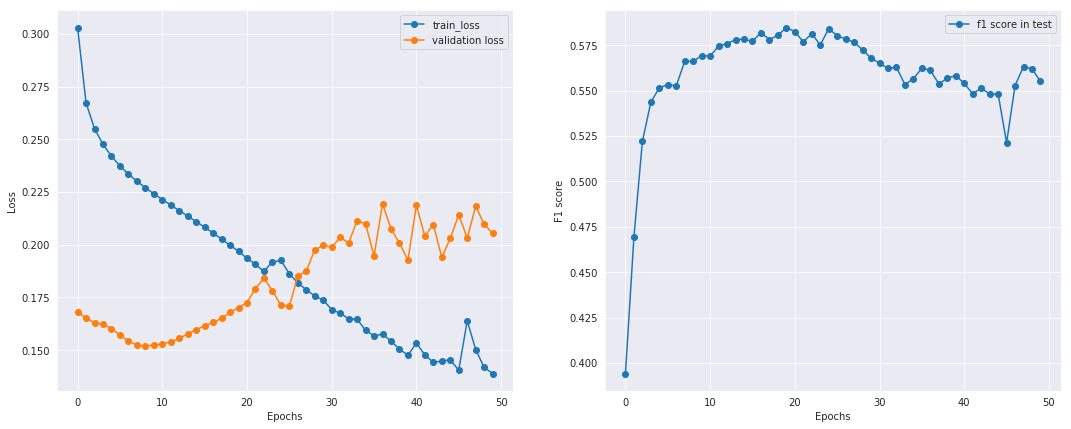





100%|██████████| 50/50 [40:57<00:00, 49.14s/it]





In [144]:
# These will usually be more like 32 or 64 dimensional.
EMBEDDING_DIM = 20
HIDDEN_DIM = 20
EPOCHS = 50

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

with torch.no_grad():
    inputs = prepare_sequence(train_data[0][0], word_to_ix)
    tag_scores = model(inputs)
#     print(tag_scores)
 
train_loss = []
test_loss = []
f1_scores_per_epoch = []

for epoch in trange(EPOCHS): 
    train_val = 0.0
    test_val = 0.0
    for sentence, tags in train_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        train_val += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss.append(train_val/len(train_data))
                
    for sentence, tags in test_data:
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)     
        
        tag_scores = model(sentence_in)
        
        loss_test = loss_function(tag_scores, targets)
        test_val += loss_test.item()
        
    test_loss.append(test_val/len(test_data))
    
    f1_scores_per_epoch.append(f1_scores(test))
    
    clear_output(wait=True)
    plot_loss_and_score(train_loss, test_loss, f1_scores_per_epoch)
            
# torch.save(model, 'Models/LSTM_20.pt')

In [147]:
np.max(f1_scores_per_epoch)

0.5847158761834367

In [145]:
# tagger_LSTM('suck my dick bitch')

In [80]:
# best so far: 0.581 (emb=20, epochs=15)

<a name="4"></a>

## Evaluation

In [113]:
evaluation = pd.read_csv('Datos/tsd_test.csv')
evaluation.head()

text
0  That's right. They are not normal. And I am st...
1  "Watch people die from taking away their healt...
2  tens years ago i contacted the PDR and suggest...
3  The parallels between the ANC and the Sicilian...
4  Intel Community: ‘How can we work for a Presid...

In [114]:
indices_evaluation = []

for text in evaluation['text']:
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_evaluation.append(prediction_index)
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text)) 

Pred: That's right. They are not normal. And I am starting from the premise that they are ABNORMAL. Proceed wth the typical racist, bigot, sexist rubbish.
Thanks!
Pred: "Watch people die from taking away their healthcare"

DING DING DING!  Winner of stupid post of the day award!
Pred: tens years ago i contacted the PDR and suggested that the time might be good to work with alaska on building a gas line.. alaska rejected them without even consideration despite china being flush with cash and hungry for gas.. and set up another infamous boondoggle.. the transcanada-exxon rip off that we are still paying for and have yet to receive anything of value.. hundreds of millions of dollars on studies.. and buyouts.. i hope china says f you alaska.. you are nothing but ignorant people..
Pred: The parallels between the ANC and the Sicilian Mafia are glaring. The ANC has always been run by a few "families" who treat the state as 'turf' ; as just one big piggy bank for their self-enrichment. The gov

Pred: Lead contained entirely within the range and cleaned up at regular intervals?  /facepalm at your idiocy.
Pred: Actually I think that those who voted for him or support him are far bigger idiots than trump is. He is what he is and what he always has been and what he always will be. People who voted for him can't claim that he mislead them.
Pred: another comment so pathetic that you have to give yourself a "like"...what a troll
Pred: self centred fools are not what we need for leaders , so go back to your TV  acting O leery.
Pred: People are tired of ALL corrupt bastardos... we don't need wedges Brother, we need to link arms and take on this corrupt government... we need a call to action, to get in the streets and shut stuff down, starting with our "elected" officials offices, status quo candidates on ALL sides.  This vote is a Corporate Coup.
Pred: Don't forget Trump Chumps are proven idiots. For example, assuming a convicted felon like say, Nelson Mandela or Ghanaian did poor qua

Pred: "What to expect..." is that Trump will say some stupid things, be predictably crude, speak about issues of which he has no knowledge, further embarrass his troubled nation, and watch his foreign hosts smile awkwardly. And his moronic fans will be impressed as always, still convinced that his ineptitude and egomania indicates strength and virtue and even the revolutionary rise of the mythical Common Man.
Pred: Nah, the only asshole is the asshole firing a rifle within city limits.
Pred: "Everybody has their thing." What an idiot.
Pred: Rude comment! How can you say that we are better off with him gone? Do you want to tell his children that? Jerk!
Pred: Fall Kabib, you are a true ignorant uneducated dunce. I could care less what your Native relatives believe. I also blame Sheldon Jackson for dividing Alaska up and handed over to different denominations. None of those folks had the right to do what they did to Native people.
Pred: Nobody's buying your nonsense...doubling down on the

Pred: You're an idiot. It's not about intestinal fortitude, it's about rational policy. We're not going to change anything in Afghanistan. I support our troops by advocating complete withdrawal from the Middle East.
Pred: I  agree, how many times have stupid Ontarians voted in this morally corrupt party now?. I'm betting they do it again!, can't fix stupid........
Pred: Time to give the opposition weapons and overthrow this jerk.
Pred: Anyone who thinks that government selling pot will keep the revenue out of the hands of the black market and criminals is a fool.
Pred: Let's hear it for pussy power!
Pred: maybe you are being stupid but i know wileybot isnt
Pred: Law enforcement complaining about people breaking the law?
Arrest them and prosecute them.
I don't see a problem here.
Now that you cant ruin some poor schmuck's life who smokes weed and you happen to catch them with it, arrest these dirtbags instead who try to hide under the cover of legalized MJ.
They should all be charged un

Pred: <Trump was a draft dodger during Vietnam.>
The president is a coward and a hypocrite who not only dodged the draft and avoided any and every opportunity to serve, but also -- as an adult, a businessman, and minor celebrity -- expressed his contempt for those who do serve by describing his sexual promiscuity, while avoiding venereal disease, as his "personal Vietnam" -- "I feel like a great and very brave soldier" said the punk who is now Commander-in-Chief. http://people.com/politics/trump-boasted-of-avoiding-stds-while-dating-vaginas-are-landmines-it-was-my-personal-vietnam/
The flag represents precisely the right to protest peacefully and lawfully; for the POTUS to describe those who exercise that right in vulgar terms and call for them to lose their jobs dishonors the flag and the country and values it represents. It is the protesters, not POTUS, who honor the flag and understand what it represents.
No one has more contempt for the flag than does Donald J. Trump. No one.
Pred:

Pred: Yes. And you're a moron if you think so.
Pred: That is absolutely ridiculous, as I pointed out in a comment above the government is based on a system of checks and balances, and the President must be held in check as well. He cannot wield unyielding power or else he is a dictator and equivalently as powerful and corrupt as someone like Putin. What he has done is put on a facade that all of you simpletons ate up, as you saw his call for less government and actual change. What you haven't realized in your blindness, however, is that he and a small faction of government officials have been taking complete control of government while forcing everyone else out. He's turning the country into a dictatorship and you should be frightened by that. He is violating ALL the principles this country was founded on, all because an uneducated populace wanted their racial, religious, and sexist bias' justified by a bigot far worse than them.
Pred: hissing?  yes they made themselves look like idiot

Pred: Lets hope she does not create more terrorist breeding grounds. Bush. Obama and Hilary really gave a boost to the spread of Islam which is pretty stupid.
Pred: B*tchy comments coming from Mister Bracco,  Principal - aged 45, and Mister Osborn, Vice Principal - aged 31. sounds like mean girls to me...from the misters that is...
Pred: What a jerk the guy is.
Pred: Don't blame Obama, those black officers probaby voted for him. Trump actually opened the scab of racism. Doesn't matter if not a slave now, if your ancestors were, ALL generations suffer. What an idiot statement. Hey, trumpets, go to church today.
Pred: "Intimidating" in those states = "making sure people are who they say they are". Lighten up DS. Or do you think your fellow liberals are too stupid to see an obvious joke.
Pred: Look at the amount of our tax dollars at work here. These people aren't saints to be sure, but this is beyond ridiculous. We have daily shootings in town nowadays and this crap is getting hundreds o

Pred: This guy may not be the best candidate to subject tRump colluding with china, but he get the point. If America believes otherwise then America is in denial and  in deep shit.
Pred: They both stink.  In my experience touring motorcyclist tend to be the best behaved and wisest.
Pred: Pelosi is too stupid.
Pred: I can't believe in a great country like this these are the best citizens we can find to represent our country to the free world. Both are childish and corrupt. I feel so sad for us. Trump is a conman. He has made and lost millions this way. That's all he knows. Hillary is a child. She will never truly take responsibility for anything. Trump is ultra right. Hillary is ultra left. We have no moderate. How can I make a choice with only these people. No 3rd party candidate has ever been elected to president to my knowledge. I saw an article somewhere that had 30 reasons Trump should not be president. Then it turned around and gave 30 reasons why Hillary should not be president. 

Pred: This is a tiresome Liberal cheerleading article. Yawn. Good for Justin in doing his job. Trump is a troll of a president so really not hard to out do charmwise and he's clearly not good with facts so again no big whoop.   Let's not carried away. Trump mostly just defeats himself because he's an ignorant idiot.
Pred: Whqat a stupid , stupid move on Cenovus´s part. Who was thier management consultant on this? Scott Saxberg from Crescent Point?
Pred: Stupid is as stupid is. Is this stupid or what?  Still sick of seeing this story a second day on the internet.
Pred: Stupid people don't think rationally.
Pred: People are so stupid. And lazy. Take advantage of anything you can for retirement. This is free money. Take it.
Pred: I hate you! You lucky bastard.
Pred: Someone should tell this jackass that loose lips sink ships.
Pred: He's a full scale idiot.
Pred: More like a testicle of himself
Pred: Liberal crap rag ADN wasted no time trashing Michael Anderson after he took his own life.


Pred: The "blood of the city" didn't carry weight in Denver, it's laughable he tried again in California. The chances he got pulled over by a Raider/49er/Charger fan is large. 

"It didn't help" I bet, what an idiot.
Pred: During the Presidential election campaign and since Trump’s election, liberals have held hundreds, perhaps thousands of demonstrations, protests and rallies against Trump, and not once have Trump supporters or conservatives showed up to engage in organized violence against them as these sick loony liberals did at the Trump rally.  It is the new norm for liberals.  Sick, sick, sick.
Pred: Trump is an effing moron as are those who support this walking disaster.
Pred: Alex is not naive
he is a partisan Liberal lap dog of Justin
Pred: Keep pushing the lies MSM about how Israel is the bad guy and Palestine is innocent. Losers
Pred: The president is the emperor who has no clothes and his cheerleaders who support all things Trump are his court of fools and dunces.
Pred: Per

Pred: Society tries to impress with high levels of thinking and intelligence and comes across lookig lk a bunch of jackasses - a recount is a waste of time and money - just move on - the better candidate won. People are so simple minded to think this is news - especially the simple minded globe and mail writers
Pred: Once again you're an idiot....10% of the country uses pot on a reg basis so people at the bank and at the courthouse and in the legislature are already using pot so by your logic any of the services you use in daily life aren't  up to snuff why don't you move to Iran where they can't drink alcohol or smoke weed it would be better suited to YOUR needs since what affects YOU should reflect the way everyone else should have to live their life...once again D rider you are an IDIOT.
Pred: In this case, anyway, I have bad news for you.

URStupid
Pred: Nice going, Trudeau. Now your $10 million payout will actually cost billions more in legal fees.

Someone please get rid of this 

Pred: 1. You're an idiot. I said nothing about medical care, and I wasn't talking about hunter/gatherers. It is a FACT that the first plastered walls were built by the SAME early farmers who also built the first grain stores. Agriculture allowed, for the first time, overproduction of food - so working for a few months a year would provide food for the rest of the year. Plaster was a major thing - it has ZERO survival value. It takes days of backbreaking labour, maintaining a fire at very high heat constantly - for no reward other than aesthetics. It's something that would never have happened in a society without an abundance of leisure time. And it's important that it did - the same fire-handling techniques they developed to make their walls smooth - was what allowed their grandchildren to smelt ore and end the stone age.
2. Yawn. I would have cared if it was related to the topic. Still a strawman.
3. That scenario you paint was never very real.
Pred: The malignant narcissist, mentally

Pred: what are you smoking? no one has uses it in decades pal, its been ripped out of buildings in renos for decades, this is not harpers fault , of pehaps you can add CHRETIEN in that mix since that LIBERAL didnt ban it either ! that claim is typical bias stupidity. ,, as for your thanks for liberals, take your paid trolling trash elsewhere, you are what canada doesnt need a shill of stupidity.
Pred: We all will die.  That is guaranteed.  

The 'death we deserve'?  Opinion only, and  subject to your personal biases, beliefs and prejudices.

A three-year old infant does not "deserve to die" or "die the death they deserve."  Nonetheless, three-year old infants still die.   

Shamans try to 'explain' such things by inventing 'theology' and 'doctrine' and other cant.  

Christian shamans, New Age shamans, Buddhist shamans, Islamic shamans.  Jewish shamans.  

Just ignorant people trying to justify their ignorance by inventing something to placate those who pay their bills.
Pred: I have re

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [120]:
evaluation['spans'] = indices_evaluation
evaluation = evaluation[['spans', 'text']]
evaluation.head()

spans  \
0                [140, 141, 142, 143, 144, 145, 146]   
1  [14, 15, 16, 54, 55, 56, 57, 59, 60, 61, 62, 7...   
2           [483, 484, 485, 486, 487, 488, 489, 490]   
3           [413, 414, 415, 416, 417, 418, 419, 420]   
4  [431, 432, 433, 434, 435, 573, 574, 575, 576, ...   

                                                text  
0  That's right. They are not normal. And I am st...  
1  "Watch people die from taking away their healt...  
2  tens years ago i contacted the PDR and suggest...  
3  The parallels between the ANC and the Sicilian...  
4  Intel Community: ‘How can we work for a Presid...

Para la evaluación se debe subir un zip con un archivo txt de la siguiente manera (al final subir el archivo `spans-pred.zip` que se produce):

In [141]:
predictions = evaluation['spans'].tolist()
ids = evaluation.index.tolist()

In [142]:
with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")
        
# Zip the predictions
! zip -r spans-pred.zip ./spans-pred.* 

  adding: spans-pred.txt (deflated 82%)


Submissions:

1. ...
2. ...